# Tutorial 6: NearestKernel

This tutorial demonstrates how to use Monte Carlo data directly to create a 2D kernel that can be used for PSF modeling in SPECT. In this case, we'll use the same Ac225 data as from tutorial 5.

In [2]:
import torch
from spectpsftoolbox.operator2d import NearestKernelOperator
from spectpsftoolbox.simind_io import get_projections, get_source_detector_distances
import pytomography
import matplotlib.pyplot as plt

Let's open the headerpaths for all the PSF kernels and load the projection data. The data was acquired at a 128x128 matrix size and 0.48 cm resolution. The point source was shifed upwards 0.24cm in x and y so that it corresponds to the center of a pixel. We thus index [1:,1:] after loading the data; that gives us an odd kernel size

In [3]:
headerpaths = [f'/disk1/ac225/440keV_PSF128_shift/point_position{i}_tot_w1.h00' for i in range(538,1638)]
respaths = [f'/disk1/ac225/440keV_PSF128_shift/point_position{i}.res' for i in range(538,1638)]
projectionss_data = get_projections(headerpaths).to(pytomography.device)[:,1:,1:]
distances = get_source_detector_distances(respaths).to(pytomography.device)

We'll normalize the projection data so thatthe PSF sums to 1:

In [4]:
projectionss_data /= projectionss_data[0:100].sum().reshape(-1,1,1) / 100

Now define the nearest kernel operator, which takes the PSF kernel closest to the corresponding image plane. We simulated over 1000 positions, so the rounding will be very close:

In [5]:
psf_operator = NearestKernelOperator(
    psf_data = projectionss_data,
    distances = distances,
    dr0 = (0.48,0.48),
)

Let's test the predictions at some various distances and pixel spacing

In [6]:
# Input size
Nx = Ny = 182
Nz = 128
distances_test = torch.linspace(0,55,Nx).to(pytomography.device)
dr = (0.48, 0.48)

# Manually create kernel size
Nk = Nz - 1 # size of the kernel
x_k = torch.arange(-(Nk-1)/2, (Nk+1)/2, 1).to(pytomography.device) * dr[0]
xv_k, yv_k = torch.meshgrid(x_k, x_k, indexing='xy')

# Create input with two point sources at x=64 index
input = torch.zeros(Nx, Ny, Nz).to(pytomography.device)
input[64,91,64] = 1
input[64,100,80] = 1

# In this case, the kernel size is as large as the input
output = psf_operator(input, xv_k, yv_k, distances_test)

Lets look at the output:

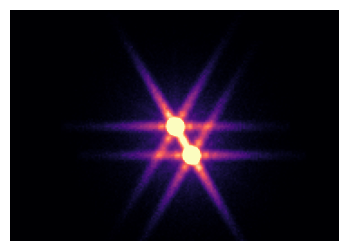

In [7]:
plt.figure(figsize=(6,3))
plt.imshow(output[64].cpu().T, cmap='magma', vmax=0.001)
plt.axis('off')
plt.show()

We can save the operator for PyTomography PSF modeling as follows:

In [8]:
psf_operator.save('/home/gpuvmadm/PointSpreadFunctionFitter/notebook_testing/psf_kernel_nearest_multi.pkl')